# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [14]:
from google.colab import files
upload=files.upload()
%ls

Saving test_inputs.csv to test_inputs.csv
Saving test_targets.csv to test_targets.csv
Saving train_inputs.csv to train_inputs.csv
Saving train_targets.csv to train_targets.csv
sample_data/     test_targets.csv  train_targets.csv
test_inputs.csv  train_inputs.csv


# Import libraries 
Do not use any other Python library.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time as time


# Function: load_generalized_linear_regression_data

This function loads the data for Generalized Linear Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_targets**: numpy array of N training targets
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_targets**: numpy array of N' test targets

In [16]:
def load_generalized_linear_regression_data():
  test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
  test_targets = np.genfromtxt('test_targets.csv', delimiter=',')
  train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
  train_targets = np.genfromtxt('train_targets.csv', delimiter=',')
  return train_inputs, train_targets, test_inputs, test_targets

# Function: predict_generalized_linear_regression

This function uses a vector of weights to make predictions for a set of inputs.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M' features)
*   **weights**: vector of weights (numpy array of M' weights)

Output:
*   **predicted_values**: vector of predicted values (numpy array of N floats)

In [17]:
def predict_generalized_linear_regression(inputs, weights):
  predicted_values = inputs.dot(weights.T)
  return predicted_values


# Function eval_generalized_linear_regression

This function evaluates a set of predictions by computing the mean squared error with respect to the targets

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M' features)
*   **weights**: vector of weights (numpy array of M' weights)
*   **targets**: vector of targets associated with the inputs (numpy array of N targets)

Output:
*   **mean_squared_error**: mean squared error between the predicted values and the targets (scalar)

In [18]:
def eval_generalized_linear_regression(inputs, weights, targets):
  error = targets-predict_generalized_linear_regression(inputs, weights)
  mean_squared_error = (1/len(inputs))*np.sum(np.power(error,2))
  return mean_squared_error

# Function train_generalized_linear_regression

This function optimizes a set of weights for generalized linear regression based on a training set

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M' features)
*   **train_targets**: vector of targets associated with the inputs (numpy array of N targets)
*   **lambda_hyperparam**: lambda hyperparameter used to adjust the importance of the regularizer (scalar)

Output:
*   **weights**: vector of weights that have been optimized (numpy array of M' weights)



In [19]:
def train_generalized_linear_regression(train_inputs, train_targets, lambda_hyperparam):
  x=train_inputs.T
  A=np.zeros([x.shape[0], x.shape[0]])
  b=np.zeros(x.shape[0])
  for i in range(x.shape[1]):
    x_p=np.reshape(x[:,i],[x[:,i].shape[0],1])
    A += x_p.dot(x_p.T)
    b += train_targets[i] * x[:,i]
  A=lambda_hyperparam * np.eye(x.shape[0])+A
  weights=np.linalg.inv(A).dot(b)
  return weights
  

# Function monomial_features

This function computes monomial basis functions up to degree $d$: $\{\prod_i (x_i)^{n_i} | \sum_i n_i \le d\}$.  A monomial of degree
less than or equal to $d$ is a product of variables (e.g., $\prod_i (x_i)^{n_i}$ where the sum of their exponents is less
than or equal to d (i.e., $\sum_i n_i \le d$).

Inputs:
*   **max_degree**: maximum degree d for the monomial basis functions (integer)
*   **inputs**: matrix of input points (numpy array of N data points x M features)

Output:
*   **features**: matrix of data points in the new feature space induced by the monomial basis functions (numpy array of N data points x M' features)

In [20]:
def total_degree(n,d):
   sum=0
   for k in range(d+1):
      a=np.math.factorial(k+n-1)
      b=np.math.factorial(k)
      c=np.math.factorial(n-1)
      sum +=a/(b*c)
   return int(sum)

def monomial_features(max_degree, inputs):
  dim2=inputs.shape[0]
  dim1=total_degree(inputs.shape[1],max_degree)
  features = np.zeros((dim2,dim1))
  for dp in range(dim2):
    ii=0
    for i in range(max_degree+1):
        for j in range(max_degree+1-i):
            features[dp,ii]=(inputs[dp,0]**i)*(inputs[dp,1]**j)
            ii += 1
  return features

#pred=total_degree(2,3)
#pred=monomial_features(3,train_inputs)
#print (pred.shape)


# Function cross_validation_generalized_linear_regression

This function performs k-fold cross validation to determine the best max degree of monomial basis functions in generalized linear regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **hyperparameters**: list of hyperparameters where each hyperparameter is a different max degree (list of integers)
*   **inputs**: matrix of input points (numpy array of N data points by M' features)
*   **targets**: vector of targets associated with the inputs (numpy array of N targets)

Outputs:
*   **best_hyperparam**: best max degree (integer)
*   **best_mean_squared_error**: mean squared error achieved with best_hyperparam (float)
*   **mean_squared_errors**: vector of mean squared errors for the corresponding hyperparameters (numpy array of floats)



In [109]:
def cross_validation_generalized_linear_regression(k_folds, hyperparameters, inputs, targets):
  dataset=np.concatenate((inputs,targets.reshape(-1,1)),axis=1)
  np.random.shuffle(dataset)
  dataset_split= np.split(dataset,k_folds)
  error_result=[]
  time_result=[]
  for max_degree in hyperparameters:
    max_degree_error = []
    max_time=[]
    for i in range(k_folds):
      test=np.array(dataset_split[i])
      train=[x for x in dataset_split if (x!=test).any()]
      train=np.array(np.concatenate(train)) 
      features_train=monomial_features(max_degree, train[:,:-1])
      features_test=monomial_features(max_degree, test[:,:-1])
      weights=train_generalized_linear_regression(features_train,train[:,-1],1)
      s= time.time()
      predicted_values=predict_generalized_linear_regression(features_train,weights)
      t= time.time()
      train_time=t-s
      error=eval_generalized_linear_regression(features_test,weights,test[:,-1])
      max_degree_error.append(error)
      max_time.append(train_time)
    error_result.append(np.mean(max_degree_error))
    time_result.append(np.mean(train_time))
  best_mean_squared_error =np.min(error_result)
  best_hyperparam =hyperparams[error_result.index(best_mean_squared_error)]
  mean_squared_errors = error_result
  time_results=time_result
  return best_hyperparam, best_mean_squared_error, mean_squared_errors, time_results


# Function: plot_generalized_linear_regression_mean_squared_errors

Function that plots the mean squared errors for different lambda values (hyperparameters) in linear regression based on cross validation

Inputs:
*   **mean_squared_errors**: vector of mean squared errors for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different degree (list of floats)

In [84]:
def plot_generalized_linear_regression_mean_squared_errors(mean_squared_errors,hyperparams):
  plt.plot(hyperparams,mean_squared_errors)
  plt.ylabel('mean squared error')
  plt.xlabel('degree')
  plt.show()
  

# Main Generalized Linear Regression code

Load data.
Use k-fold cross validation to find the best max degree of the monomial basis functions.
Plot mean squared errors for different degrees.
Test generalized linear regression with the best degree.

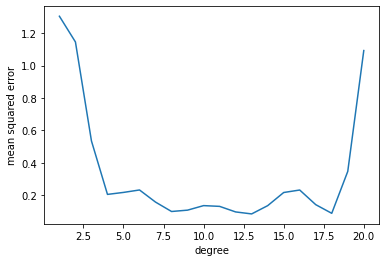

best degree: 13
best cross validation mean squared error: 0.08334051482601965
test mean squared error: 0.08348528877240749


In [123]:
# load data
train_inputs, train_targets, test_inputs, test_targets = load_generalized_linear_regression_data()

# hyperparams (degrees) to be evaluated by cross validation
hyperparams = range(1,21)
k_folds = 10
best_degree, best_mean_squared_error, mean_squared_errors, time_results = \
  cross_validation_generalized_linear_regression(k_folds,hyperparams,train_inputs,train_targets)

# plot results
plot_generalized_linear_regression_mean_squared_errors(mean_squared_errors,hyperparams)
print('best degree: ' + str (best_degree))
print('best cross validation mean squared error: ' + str(best_mean_squared_error))

# train and evaluate with best degree
lambda_value = 1
generalized_train_inputs = monomial_features(best_degree, train_inputs)
generalized_test_inputs = monomial_features(best_degree, test_inputs)
weights = train_generalized_linear_regression(generalized_train_inputs,train_targets,lambda_value)
mean_squared_error = eval_generalized_linear_regression(generalized_test_inputs, weights, test_targets)
print('test mean squared error: ' + str(mean_squared_error))


Question
=================
What is the training time complexity of generalized linear regression as a function of the amount of training data, the dimensionality of the data in the original feature space and the maximum degree of the monomial basis functions?



Lets plot the run time for training the data in each degree

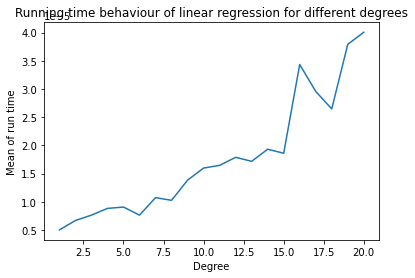

In [124]:
 plt.plot(hyperparams,time_results)

 plt.title("Running time behaviour of linear regression for different degrees")
 plt.xlabel("Degree")
 plt.ylabel("Mean of run time")
 plt.show()

The previous figure illustrates that a higher degree for the monomial basis function needs more time for training the mode. The figure leads us to this conclusion that complexity and amount of data plays a major role in runnig time and training a model